In [1]:
# Tratamiento de datos
# ================================================================================================================
import pandas as pd
import numpy as np

# Preprocesado y modelado
# ================================================================================================================
from sklearn.model_selection import PredefinedSplit, cross_validate, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Métricas
# ================================================================================================================
from sklearn.metrics import make_scorer, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import median_absolute_error
import time
from sklearn.inspection import permutation_importance

# Gráficos
# ================================================================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# MLFLOW
# ================================================================================================================
import mlflow
mlflow.set_tracking_uri('sqlite:///mlflow.db')

# Configuración warnings
# ================================================================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import sys

# Añadimos la carpeta 'drive' al path
ruta_carpeta_drive = os.path.abspath('../drive') #.. era para salirse de la carpeta actual y entrar en la de drive
if ruta_carpeta_drive not in sys.path:
    sys.path.insert(0, ruta_carpeta_drive)

import drive

# Descargamos los datos en formato parquet de Google Drive
# guardar localmente
drive.descargar_archivos_concretos('DfAnterior.csv', '../drive')
drive.descargar_archivos_concretos('DfTest.csv', '../drive')

#hay que pasarle la ruta a la carpeta drive desde donde lo estamos ejecutando
# y el nombre del archivo que hemos puesto en el archivos_info.txt (MLP_runs.db en nuestro ejemplo, en vez de datosEntrenamiento.parquet...)
# leer para utilizar esto ya en el modelo
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

Mostrar las distribuciones del precio máximo (variable objetivo) de train y test.

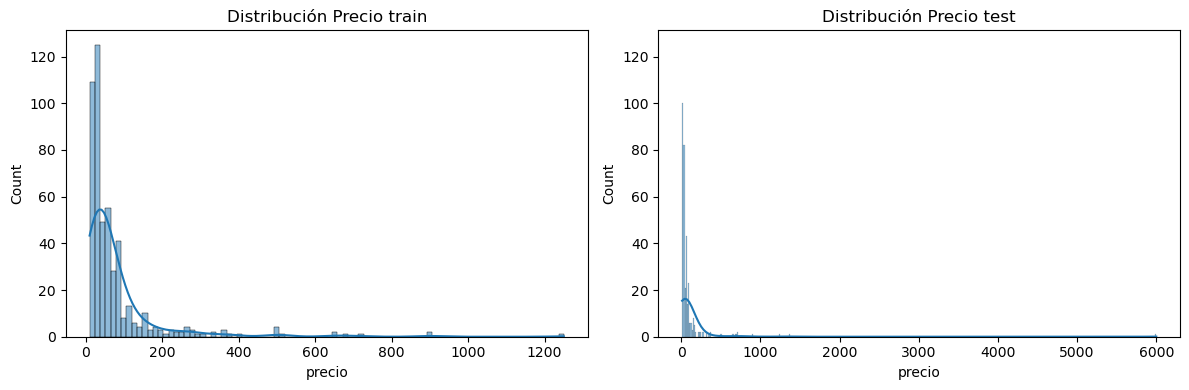

In [3]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(data=data_train, x='max_price', kde=True, ax=ax1)
ax1.set_title("Distribución Precio train")
ax1.set_xlabel('precio')

sns.histplot(data=data_test, x='max_price', kde=True, ax=ax2)
ax2.set_title("Distribución Precio test")
ax2.set_xlabel('precio')

# Encontrar el valor máximo de y en ambos gráficos
y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

# Establecer el mismo límite para ambos ejes y
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, y_max)

plt.tight_layout()
plt.show()


Nos quedamos ahora con los precios por debajo de 100€ como ya hicimos con los modelos de la última entrega.

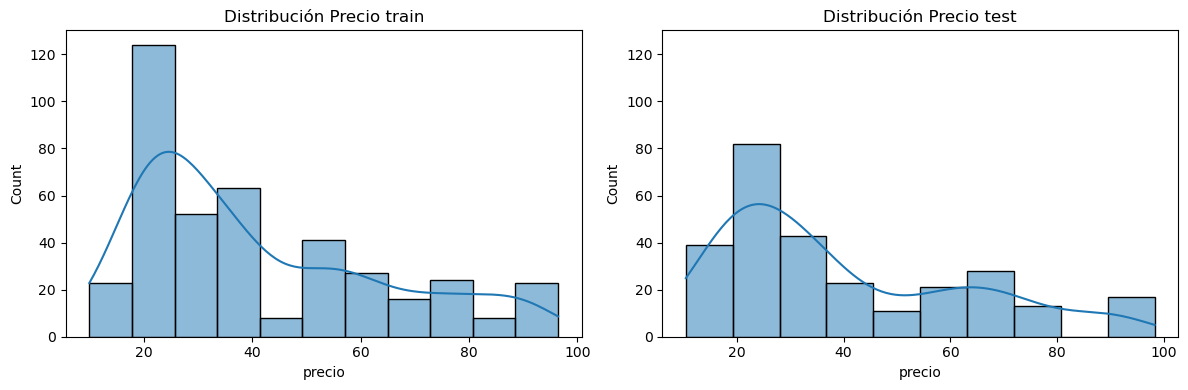

In [4]:
test_new = data_test[data_test['max_price'] < 100]
train_new = data_train[data_train['max_price'] < 100]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(data=train_new, x='max_price', kde=True, ax=ax1)
ax1.set_title("Distribución Precio train")
ax1.set_xlabel('precio')

sns.histplot(data=test_new, x='max_price', kde=True, ax=ax2)
ax2.set_title("Distribución Precio test")
ax2.set_xlabel('precio')

# Encontrar el valor máximo de y en ambos gráficos
y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

# Establecer el mismo límite para ambos ejes y
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, y_max)

plt.tight_layout()
plt.show()


In [5]:
# Eliminamos las categoricas
columnas=['name','EventStartTime', 'SalesStartTIme', 'SalesEndTime', 'nameArtist', 'VenueName',
          'VenueCity', 'VenueState','Generos_combinados', 'min_price']

train = train_new.drop(columnas, axis=1)
train = train.drop('fold', axis=1)
test = test_new.drop(columnas, axis=1)

RANDOM_STATE = 83 #fijamos la semilla

# Los atributos que necesitan un escalado
no_binarias = ['num_links', 'seguidoresSpotify', 'popularidad', 'subsYT', 'NumGeneros', 'peso_promotor',
               'conciertos_del_artista_en_ciudad', 'dias_Venta', 'dias_desdeFinVenta', 'num_noches']

In [6]:
def plot_model_predictions(mlp, X_train, y_train, X_test, y_test, data):
    '''
    Función para mostrar en una gráfica las preddicciones de un modelo y sus valores reales.
    '''
    # Entrenar el modelo 
    mlp.fit(X_train, y_train)
    # Realiza predicciones con el pipeline ajustado
    predicciones = mlp.predict(X_test)

    # Crea un DataFrame con los precios reales, predichos y el nombre del concierto
    df = pd.DataFrame({'Nombre del Concierto': data['name'], 'Precio Real': y_test, 'Precio Predicho': predicciones})

    # Crea un scatter plot interactivo con Plotly
    fig = px.scatter(df, x='Precio Real', y='Precio Predicho', color='Nombre del Concierto',
                     title='Comparación de Precios Reales vs Precios Predichos',
                     labels={'Precio Real': 'Precio Real', 'Precio Predicho': 'Precio Predicho'})

    # Agrega una línea diagonal que representa la igualdad entre los precios reales y predichos
    fig.add_shape(type='line',
                  x0=df['Precio Real'].min(), y0=df['Precio Real'].min(),
                  x1=df['Precio Real'].max(), y1=df['Precio Real'].max(),
                  line=dict(color='red', width=2, dash='dash'))
    
    fig.show()

In [7]:
def feature_importance(pipeline, X_train, y_train, X_test, y_test, top_n, random_state=RANDOM_STATE):
    '''
    Función para mostrar las top_n variables más influyentes con el método permutation_importance.
    '''
    pipeline.fit(X_train, y_train)  # Asegúrate de que el modelo esté ajustado

    # Calculando la importancia de las características
    importance = permutation_importance(pipeline, X_train, y_train, n_repeats=30, random_state=random_state, scoring='neg_mean_squared_error')

    # Graficar la importancia de las características
    feature_names = X_train.columns
    sorted_idx = importance.importances_mean.argsort()[::-1]  # Ordenar de mayor a menor

    # Seleccionar los top_n más importantes
    top_features = sorted_idx[:top_n]
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=importance.importances_mean[top_features], y=feature_names[top_features], palette="viridis")
    plt.xlabel("Importancia de la característica (promedio de reducción de score)", fontsize=10)
    plt.ylabel("Características", fontsize=10)
    plt.title(f"Top {top_n} características más importantes usando Permutation Feature Importance", fontsize=10)
    
    # Añadir etiquetas de los valores en las barras
    for index, value in enumerate(importance.importances_mean[top_features]):
        plt.text(value, index, f'{value:.2f}', va='center', ha='right', color='black', fontsize=8)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().invert_yaxis()  # Invertir el eje y para que el más importante esté en la parte superior
    plt.tight_layout()
    plt.show()

In [8]:

def rmse_with_respect_to_median(predictions, actuals):
    """
    Calcula el RMSE respecto a la mediana de los valores reales.
    """
    # Convertir a arrays de numpy por si están en otro formato
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Calcular la mediana de los valores reales
    median_actuals = np.median(actuals)
    
    # Calcular los errores al cuadrado respecto a la mediana
    squared_errors = (predictions - median_actuals) ** 2
    
    # Calcular el error cuadrático medio
    mse = np.mean(squared_errors)
    
    # Calcular la raíz cuadrada del error cuadrático medio
    rmse = np.sqrt(mse)
    
    return rmse

def mape_with_respect_to_median(predictions, actuals):
    """
    Calcula el MAPE respecto a la mediana de los valores reales.
    """
    # Convertir a arrays de numpy por si están en otro formato
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Calcular la mediana de los valores reales
    median_actuals = np.median(actuals)
    
    # Calcular los errores absolutos porcentuales respecto a la mediana
    percentage_errors = np.abs(predictions - median_actuals) / median_actuals
    
    # Calcular el error absoluto porcentual medio
    mape = np.mean(percentage_errors) * 100
    
    return mape


Ahora dividimos en x e y.

In [9]:
# Definir la variable objetivo y las características
y_train = train['max_price']
X_train = train.drop('max_price', axis=1)

# Definir la variable objetivo y las características
y_test = test['max_price']
X_test = test.drop('max_price', axis=1)

Si se diera el caso de que test o train tienen columnas que no tiene el otro provocaría errores en el modelo. Esto puede ocurrir con las varibales de los géneros musicales. Para que no de problemas simplemente añadimos las columnas que no estén a 0, dando a entender que no tienen esos géneros.


In [10]:
# Columnas que están en X_train pero no en X_test
columns_only_in_train = X_train.columns.difference(X_test.columns).tolist()

# Columnas que están en X_test pero no en X_train
columns_only_in_test = X_test.columns.difference(X_train.columns).tolist()

print("Columnas solo en X_train:", columns_only_in_train)
print("Columnas solo en X_test:", columns_only_in_test)

# Agregar columnas faltantes en X_test con valor 0
for column in columns_only_in_train:
    X_test[column] = 0

# Agregar columnas faltantes en X_train con valor 0 (si es necesario)
for column in columns_only_in_test:
    X_train[column] = 0

Columnas solo en X_train: ['New Wave', 'Performance Art']
Columnas solo en X_test: []


In [11]:

# Definir el ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', RobustScaler(), no_binarias)
    ],
    remainder='passthrough'  # Deja las otras columnas sin cambios
)

# Definir el pipeline con el ColumnTransformer y el modelo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('mlp', MLPRegressor(
        random_state=42,
        activation='relu',
        alpha=0.0001,
        hidden_layer_sizes=(1,),
        learning_rate='constant',
        solver='lbfgs'
    ))
])

# Entrenar el modelo con los datos de entrenamiento
pipeline.fit(X_train, y_train)

# Hacer predicciones en los datos de entrenamiento y prueba
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Calcular las métricas para el conjunto de entrenamiento
metrics_train = {
    'MedAE': median_absolute_error(y_train, y_train_pred),
    'MedAPE': mape_with_respect_to_median(y_train_pred, y_train),
    'MedRMSE':rmse_with_respect_to_median(y_train_pred, y_train),
    'MAPE': mean_absolute_percentage_error(y_train, y_train_pred),
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred))
}

# Calcular las métricas para el conjunto de prueba
metrics_test = {
    'MedAE': median_absolute_error(y_test, y_test_pred),
    'MedAPE': mape_with_respect_to_median(y_test_pred, y_test),
    'MedRMSE': rmse_with_respect_to_median(y_test_pred, y_test),
    'MAPE': mean_absolute_percentage_error(y_test, y_test_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))
}

print("Métricas para el conjunto de entrenamiento:")
for metric_name, metric_value in metrics_train.items():
    print(f"{metric_name} train: {metric_value:.4f}")

print("\nMétricas para el conjunto de prueba:")
for metric_name, metric_value in metrics_test.items():
    print(f"{metric_name} test: {metric_value:.4f}")

Métricas para el conjunto de entrenamiento:
MedAE train: 16.7000
MedAPE train: 19.7260
MedRMSE train: 7.0595
MAPE train: 0.5629
RMSE train: 22.0729

Métricas para el conjunto de prueba:
MedAE test: 18.3000
MedAPE test: 29.1350
MedRMSE test: 9.4597
MAPE test: 0.6326
RMSE test: 22.4995


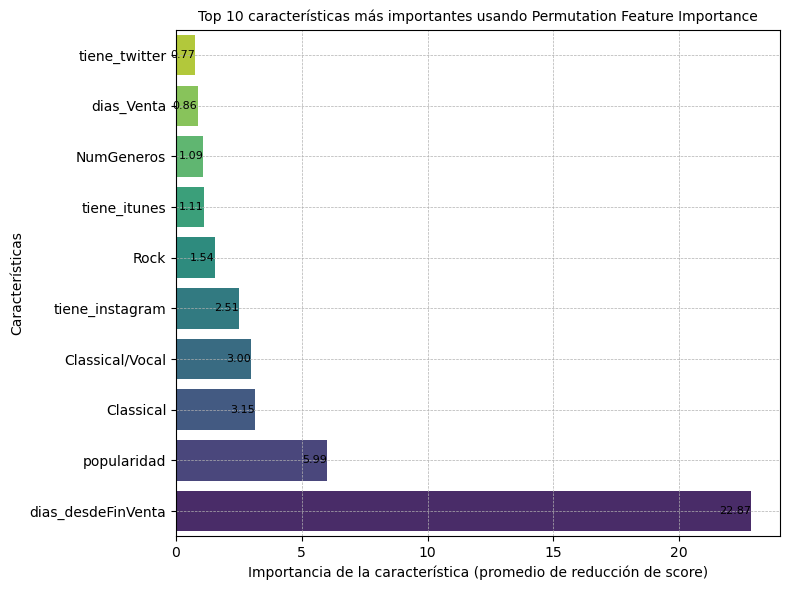

In [12]:
plot_model_predictions(pipeline, X_train, y_train, X_test, y_test, test_new)
feature_importance(pipeline, X_train, y_train, X_test, y_test, 10)

   VenueClass         mse       rmse      mape
0           2  658.389313  25.659098  0.403456
1           1  579.134986  24.065224  0.351881
2           0  442.155837  21.027502  0.797512


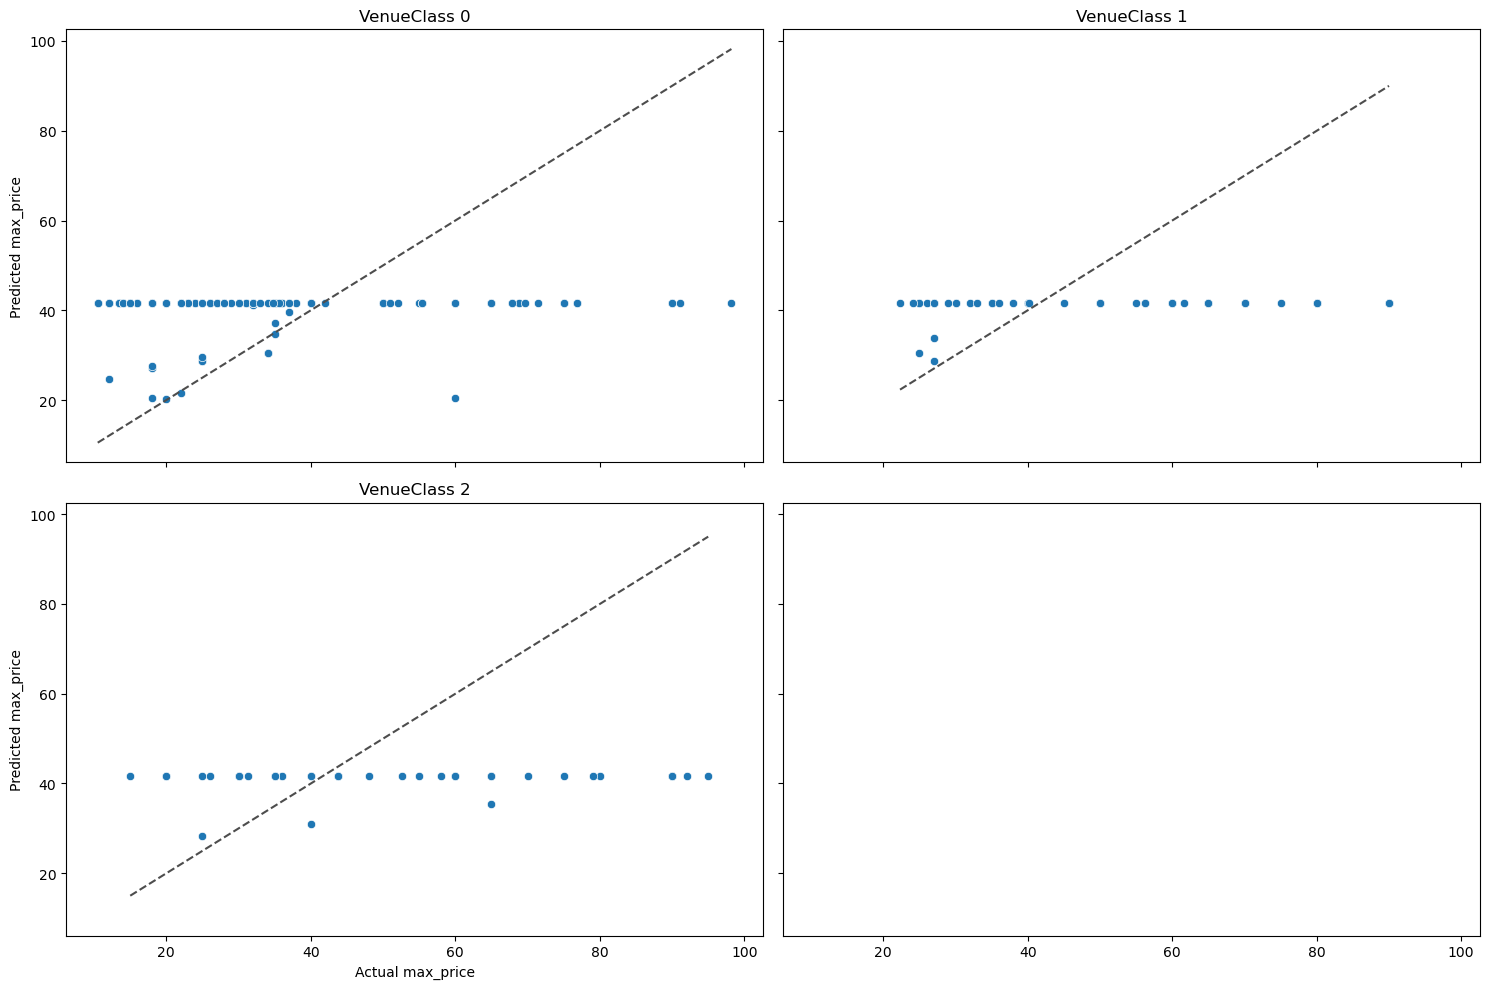

In [13]:

# Copiar el DataFrame original
datos_segmentos = test_new.copy()
# Añadir las predicciones al DataFrame
datos_segmentos['pred'] = y_test_pred

# Lista para almacenar los resultados
resultados_list = []

# Calcular las métricas para cada valor de "VenueClass"
for vc in datos_segmentos['VenueClass'].unique():
    subset = datos_segmentos[datos_segmentos['VenueClass'] == vc]
    mse = mean_squared_error(subset['max_price'], subset['pred'])
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(subset['max_price'], subset['pred'])
    resultados_list.append({'VenueClass': vc, 'mse': mse, 'rmse': rmse, 'mape': mape})

# Convertir la lista de resultados en un DataFrame
resultados = pd.DataFrame(resultados_list)
print(resultados)

# Configurar la figura y los ejes
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

# Ordenar los datos
venue_classes = sorted(datos_segmentos['VenueClass'].unique())

# Generar gráficos de dispersión para cada "VenueClass"
for idx, vc in enumerate(venue_classes):
    subset = datos_segmentos[datos_segmentos['VenueClass'] == vc]
    ax = axes[idx//2, idx%2]  # Ubicación del gráfico en la cuadrícula
    sns.scatterplot(ax=ax, x=subset['max_price'], y=subset['pred'])
    ax.plot([subset['max_price'].min(), subset['max_price'].max()],
            [subset['max_price'].min(), subset['max_price'].max()],
            ls="--", c=".3")
    ax.set_title(f'VenueClass {vc}')
    ax.set_xlabel('Actual max_price')
    ax.set_ylabel('Predicted max_price')

plt.tight_layout()
plt.show()


Vemos que no hay ninguna muestra del venue tipo 3 (estadios muy grandes).

In [14]:
test_new['VenueClass'].unique()

array([2, 1, 0], dtype=int64)